## Set Up DuckDB

In [2]:
import duckdb
duckdb.sql('SELECT 42').show()

┌───────┐
│  42   │
│ int32 │
├───────┤
│    42 │
└───────┘



In [3]:
con = duckdb.connect()
duckdb.sql('SELECT * FROM "ingest/bank-data.parquet" limit 3')#.df() method return pandas dataframe

┌─────────────────────┬──────────────────┬─────────┬──────────────┬───────────────┬─────────────┬───────────┐
│        Date         │   Description    │  Type   │ Money In (£) │ Money Out (£) │ Balance (£) │ Category  │
│      timestamp      │     varchar      │ varchar │    double    │    double     │   double    │  varchar  │
├─────────────────────┼──────────────────┼─────────┼──────────────┼───────────────┼─────────────┼───────────┤
│ 2023-10-02 00:00:00 │ STGCOACH/CTYLINK │ DEB     │          0.0 │           2.0 │      5770.0 │ Transport │
│ 2023-10-02 00:00:00 │ PRET A MANGER    │ DEB     │          0.0 │           5.0 │      5764.0 │ Cafe      │
│ 2023-10-02 00:00:00 │ STGCOACH/CTYLINK │ DEB     │          0.0 │           2.0 │      5762.0 │ Transport │
└─────────────────────┴──────────────────┴─────────┴──────────────┴───────────────┴─────────────┴───────────┘

In [ ]:
import duckdb

with duckdb.connect('file.db') as con:
    con.sql('CREATE TABLE test(i INTEGER)')
    con.sql('INSERT INTO test VALUES (42)')
    con.table('test').show()

In [6]:
con=duckdb.connect('file.db')
con.table('test')

con.install_extension("spatial")
con.install_extension("spatial")

## Details
Create a DuctDBPyConnection object. You can then use this connection with python `with` as live connection object.
- If the database file does not exist, it will be created
- the file extension may be .db, .duckdb, or anything else
- The special value :memory: (the default) can be used to create an in-memory database.
- Read-only mode is required if multiple Python processes want to access the same database file at the same time.
- providing the special value :default: to connect.


### Parametrised Query

In [7]:
duckdb.execute("""
    SELECT
        $my_param,
        $other_param,
        $also_param
    """,
    {
        'my_param': 5,
        'other_param': 'DuckDB',
        'also_param': [42]
    }
).fetchall()

[(5, 'DuckDB', [42])]

In [8]:
# create a table
con.execute("CREATE TABLE items(item VARCHAR, value DECIMAL(10, 2), count INTEGER)")
# insert two items into the table
con.execute("INSERT INTO items VALUES ('jeans', 20.0, 1), ('hammer', 42.2, 2)")

# retrieve the items again
con.execute("SELECT * FROM items")
print(con.fetchall())

[('jeans', Decimal('20.00'), 1), ('hammer', Decimal('42.20'), 2)]


In [9]:
con.execute("SELECT * FROM items")
print(con.fetchall())

[('jeans', Decimal('20.00'), 1), ('hammer', Decimal('42.20'), 2)]


### Replacement Scan

In [10]:
my_statement = duckdb.sql('SELECT * FROM "ingest/bank-data.parquet"')

In [11]:
duckdb.sql("select * from my_statement order by random() limit 3")

┌─────────────────────┬────────────────────┬─────────┬──────────────┬───────────────┬─────────────┬────────────────┐
│        Date         │    Description     │  Type   │ Money In (£) │ Money Out (£) │ Balance (£) │    Category    │
│      timestamp      │      varchar       │ varchar │    double    │    double     │   double    │    varchar     │
├─────────────────────┼────────────────────┼─────────┼──────────────┼───────────────┼─────────────┼────────────────┤
│ 2023-11-23 00:00:00 │ TESCO STORES 2487  │ DEB     │          0.0 │           3.0 │      3777.0 │ Food & Grocery │
│ 2023-06-14 00:00:00 │ COSTA COFFEE 43011 │ DEB     │          0.0 │           6.0 │      3590.0 │ Cafe           │
│ 2023-06-08 00:00:00 │ CO-OP GROUP 070527 │ DEB     │          0.0 │           4.0 │      4341.0 │ Food & Grocery │
└─────────────────────┴────────────────────┴─────────┴──────────────┴───────────────┴─────────────┴────────────────┘

In [12]:
duckdb.sql('''
           select *, date_trunc('week', Date) as month
           from my_statement
           where Category != 'Rent & Essential'
           ''')\
           .aggregate('month, round(sum("Money Out (£)")/7, 2) as avg_per_day')\
           .aggregate('round(mean(avg_per_day), 2)')

┌─────────────────────────────┐
│ round(mean(avg_per_day), 2) │
│           double            │
├─────────────────────────────┤
│                       67.77 │
└─────────────────────────────┘

### aggregate(): this is part of ibis frameworkd

In [13]:
my_statement.aggregate('Category as g, sum("Balance (£)")')

┌──────────────────┬────────────────────┐
│        g         │ sum("Balance (£)") │
│     varchar      │       double       │
├──────────────────┼────────────────────┤
│ Rent & Essential │            28377.0 │
│ Cafe             │           457548.0 │
│ Cloth & Shopping │            19190.0 │
│ Transport        │           644101.0 │
│ Subscri & Apple  │           251391.0 │
│ Other            │          1283628.0 │
│ Food & Grocery   │           682436.0 │
└──────────────────┴────────────────────┘

### Jupyter Extensions

In [14]:
%load_ext sql
conn = duckdb.connect()
%sql conn --alias duckdb

In [ ]:
%sql select * from my_statement order by random() limit 3

Running query in 'duckdb'

Date,Description,Type,Money In (£),Money Out (£),Balance (£),Category
2023-08-31 00:00:00,FULL FIBRE LIMITED,BGC,2327.0,0.0,5153.0,Other
2023-08-31 00:00:00,STGCOACH/CTYLINK,DEB,0.0,2.0,5154.0,Transport
2023-10-02 00:00:00,EXETER CITY COUNCI,DD,0.0,29.0,5666.0,Subscri & Apple


In [ ]:
%%sql
select * 
from my_statement
where "Money Out (£)" > 100

Running query in 'duckdb'

Date,Description,Type,Money In (£),Money Out (£),Balance (£),Category
2023-10-16 00:00:00,AllSaints Exeter,DEB,0.0,130.0,4753.0,Other
2023-10-26 00:00:00,APPLE,DEB,0.0,1099.0,3273.0,Subscri & Apple
2023-10-30 00:00:00,STEPHEN GIBSON,FPO,0.0,350.0,2808.0,Rent & Essential
2023-11-06 00:00:00,TIME FLIES,DEB,0.0,175.0,4485.0,Other
2023-11-20 00:00:00,WH Smith Exeter,DEB,0.0,102.0,3892.0,Other
2023-11-27 00:00:00,AMZNMktplace,DEB,0.0,133.0,3468.0,Other
2023-11-27 00:00:00,STEPHEN GIBSON,FPO,0.0,350.0,3065.0,Rent & Essential
2023-11-29 00:00:00,UKVISAFEE6JAA02219,DEB,0.0,827.0,2176.0,Rent & Essential
2023-11-29 00:00:00,IHS123411215PA01 2,DEB,0.0,1248.0,928.0,Other
2023-07-03 00:00:00,TRAINLINE,DEB,0.0,106.0,4376.0,Transport


### Ploting without load data to in memory

<Axes: title={'center': "'Money Out (£)' from 'my_statement'"}, xlabel='Money Out (£)', ylabel='Count'>

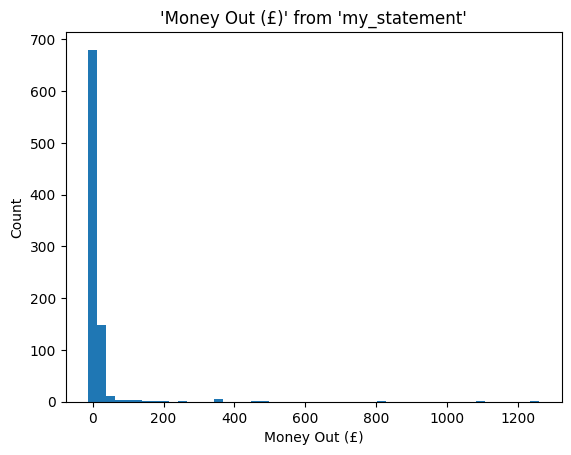

In [ ]:
%sqlplot histogram --column "Money Out (£)" --table my_statement

### ggplot api (in development)

In [16]:
%%sql 
clean_statement << select --save to a variable
    Category,
    "Money Out (£)" as Spending
    from my_statement

Running query in 'duckdb'

In [17]:
type(clean_statement)
import pandas as pd

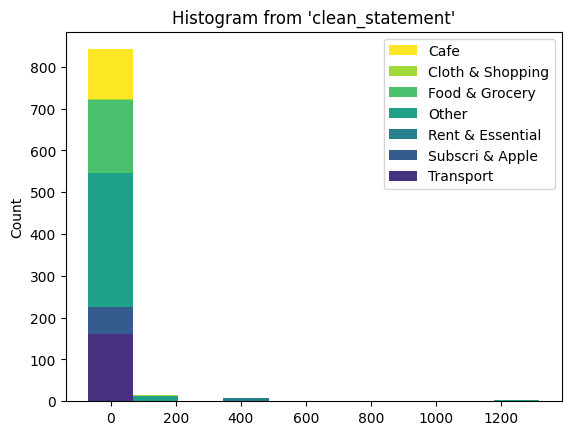

In [18]:
clean_statement = clean_statement.DataFrame() if type(clean_statement) is not pd.DataFrame else clean_statement # the result must be converted to DataFrame to allow ploting in the next line
from sql.ggplot import ggplot, aes, geom_boxplot, geom_histogram, facet_wrap
(
    ggplot(table="clean_statement", mapping=aes(x="Spending")) +
    geom_histogram(bins=10,fill="Category")
)

### About Ibis Framework

In [ ]:
%pip install ibis

11703.48s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.
